In [1]:
import torch
import torch.nn as nn
from torch_geometric.datasets import TUDataset
import networkx as nx
import numpy as np
import torch.optim as optim
import random
from sklearn.metrics import confusion_matrix
import seaborn as sns
import torch_geometric.transforms as T
import matplotlib.pyplot as plt
import sys
sys.path.append('..')
import binary_class
import functions.adj_matrix_functions as adj
import functions.overall_functions as overall_functions

In [2]:
overall_functions.set_all_seeds(42)

In [3]:
dataset = TUDataset('proteins', 'PROTEINS')
dataset.transform = T.NormalizeFeatures()
dataset

c:\Users\szige\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch_geometric\data\dataset.py:238: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  if osp.exists(f) 

PROTEINS(1113)

In [4]:
X = [x.x for x in dataset]
y = torch.cat([x.y for x in dataset]).to(torch.float)
adj_matrices = [adj.create_adj_matrix(x.num_nodes, x.edge_index.T) for x in dataset]
len(X), y.shape, len(adj_matrices)

(1113, torch.Size([1113]), 1113)

In [5]:
train_indices, val_indices, test_indices = overall_functions.get_indices(len(dataset), 0.8, 0.1)
len(train_indices), len(val_indices), len(test_indices)

(890, 111, 112)

In [6]:
batch_size = 16
X_train, y_train, adj_train, indices_train = adj.get_batched_data([X[i] for i in train_indices], y[train_indices], [adj_matrices[i] for i in train_indices], batch_size)
X_val, y_val, adj_val, indices_val = adj.get_batched_data([X[i] for i in val_indices], y[val_indices], [adj_matrices[i] for i in val_indices], batch_size)
X_test, y_test, adj_test, indices_test = adj.get_batched_data([X[i] for i in test_indices], y[test_indices], [adj_matrices[i] for i in test_indices], batch_size)

len(X_train), len(y_train), len(adj_train), len(indices_train), len(X_val), len(y_val), len(adj_val), len(indices_val), len(X_test), len(y_test), len(adj_test), len(indices_test)

(56, 56, 56, 56, 7, 7, 7, 7, 7, 7, 7, 7)

In [7]:
X_train[1].shape, adj_train[1].shape

(torch.Size([714, 3]), torch.Size([714, 714]))

In [8]:
class GNN(nn.Module):
    def __init__(self, in_features: int, out_features: int):
        super(GNN, self).__init__()
        self.pre_mlp = nn.Linear(in_features, 16)
        self.layernorm1 = nn.LayerNorm(16)
        self.layer1 = adj.GraphAttentionLayer(16, 32, 4, 0.2, 0.2)
        self.layernorm2 = nn.LayerNorm(32)
        self.layer2 = adj.GraphAttentionLayer(32, 32, 4, 0.2, 0.2)
        self.layernorm3 = nn.LayerNorm(32)
        self.linear = nn.Linear(32, out_features)
        self.skip_connection = nn.Linear(16, 32)

        
    def forward(self, features: torch.Tensor, edge_index: torch.Tensor, indices:torch.Tensor):
        features = self.pre_mlp(features)
        features = self.layernorm1(features)
        features = torch.relu(features)

        features_skip = self.skip_connection(features)
        features = self.layer1(features, edge_index)
        features = self.layernorm2(features)
        features = torch.relu(features + features_skip)

        features_skip = features
        features = self.layer2(features, edge_index)
        features = self.layernorm3(features)
        features = torch.relu(features + features_skip)

        readout = self.pooling(features, indices)
        readout = self.linear(readout)
        return readout        

    def pooling(self, features: torch.Tensor, indices: torch.Tensor):
        graph_embedding = torch.zeros(indices.max().item() + 1, features.size(1))
        graph_embedding = graph_embedding.index_add(0, indices, features)
        count = torch.bincount(indices)
        graph_embedding = graph_embedding / count.unsqueeze(1)
        return graph_embedding

In [9]:
in_features = X[0].shape[-1]
hidden_features = 8
out_features = 1
model = GNN(in_features, out_features)

In [10]:
num_epochs = 10
learning_rate = 0.01
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
loss_fn = nn.BCEWithLogitsLoss()
patience = 3

binary_class.fit(model, num_epochs, patience, optimizer, loss_fn, X_train, adj_train, indices_train, y_train, X_val, adj_val, indices_val, y_val)

Epoch: 1 | Train Loss: 0.6706 | Val Loss: 0.6417 | Val acc: 0.6393
Epoch: 2 | Train Loss: 0.6369 | Val Loss: 0.6323 | Val acc: 0.6577
Epoch: 3 | Train Loss: 0.6245 | Val Loss: 0.6255 | Val acc: 0.6685
Epoch: 4 | Train Loss: 0.6192 | Val Loss: 0.6079 | Val acc: 0.694
Epoch: 5 | Train Loss: 0.6161 | Val Loss: 0.6044 | Val acc: 0.6851
Epoch: 6 | Train Loss: 0.6116 | Val Loss: 0.5954 | Val acc: 0.6952
Epoch: 7 | Train Loss: 0.6085 | Val Loss: 0.5968 | Val acc: 0.6857
Epoch: 8 | Train Loss: 0.6071 | Val Loss: 0.6138 | Val acc: 0.6851
Epoch: 9 | Train Loss: 0.6044 | Val Loss: 0.6039 | Val acc: 0.703
Early stop


In [11]:
test_logits, test_labels = binary_class.get_test(model, X_test, adj_test, indices_test, y_test)

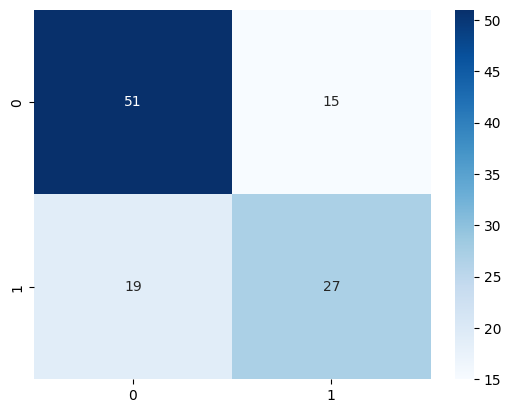

In [12]:
sns.heatmap(confusion_matrix(test_labels, test_logits), annot=True, cmap='Blues')
plt.show()

In [13]:
binary_class.accuracy_fn(test_logits, test_labels)

tensor(0.6964)